In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from reservoirpy.nodes import Reservoir, Ridge, Input, ScikitLearnNode
import seaborn as sns
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    RobustScaler,
    QuantileTransformer,
)


from model_configurations import ModelConfiguration
from utils import get_quantiles_individuals


pd.options.display.max_rows = 20
pd.options.display.max_columns = 300
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize": (15, 10)})

In [2]:
CSV_FILE = "../../data/synthetic_bph_1/simulation.csv"

In [3]:
data = pd.read_csv(CSV_FILE, sep=";", decimal=",")
data = data.sort_values(by=["individus", "temps"])
data

,individus,temps,x1,x1_obs,x2,x2_obs,x3,x3_obs,x4,x4_obs,x5,x5_obs,x6,x6_obs,x7,x7_obs,x8,y_mixed,y_mixed_obs,y_fixed,y_fixed_obs
0,1,0,0.890634,0.941455,-1.008267,-0.988229,0.264669,0.361084,-0.648976,-0.730239,3.257709e-01,0.322978,2.945083,2.900945,-0.744555,-0.744548,0,-1.678414,-1.782819,-2.072956,-2.057110
1,1,1,0.166724,0.704385,-1.164905,-1.226294,0.264059,0.256220,-0.574728,-0.558283,4.220333e-01,0.421475,3.322322,3.421178,-0.631873,-0.623578,0,-1.919671,-1.873649,-2.530125,-2.419892
2,1,2,-0.557185,-0.697930,-1.256533,-1.332657,0.262231,0.185409,-0.507545,-0.526535,5.028353e-01,0.500725,3.722287,3.718409,-0.524238,-0.519302,0,-1.924473,-1.997926,-2.830060,-2.902343
3,1,3,-1.281095,-0.733795,-1.321543,-1.411484,0.259184,0.347365,-0.446756,-0.479332,5.612743e-01,0.561387,4.144980,4.093975,-0.425830,-0.419581,0,-1.803903,-1.854510,-3.062598,-2.978146
4,1,4,-2.005005,-1.866516,-1.371970,-1.376444,0.254919,0.345040,-0.391751,-0.172551,5.991411e-01,0.595408,4.590399,4.583761,-0.339396,-0.340374,0,-1.635467,-1.675288,-3.277499,-3.235019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-73.726145,-73.652941,0.432651,0.464711,-0.214545,-0.244244,0.266649,0.255834,-1.292289e-17,-0.001200,1.476509,1.440325,-1.328121,-1.326202,1,1.739175,1.718363,0.593690,0.507568
25496,500,47,-75.354554,-75.449685,0.428917,0.612389,-0.258311,-0.249547,0.266401,0.164552,-5.581364e-18,-0.000893,1.578360,1.587577,-1.332378,-1.333835,1,1.771572,1.809840,0.619710,0.606283
25497,500,48,-76.982963,-76.534494,0.425260,0.403345,-0.303018,-0.279160,0.266177,0.312715,-2.410577e-18,0.002469,1.683608,1.674245,-1.336399,-1.329781,1,1.804660,1.964220,0.646286,0.483667
25498,500,49,-78.611371,-79.112450,0.421677,0.315975,-0.348666,-0.344530,0.265974,0.271925,-1.041122e-18,-0.003460,1.792253,1.821948,-1.340198,-1.339676,1,1.838422,1.878651,0.673402,0.698870


We'll use:
- features without noise
- target with noise and without random effects

In [4]:
group_labels = ["individus", "temps"]

x_labels = [l for l in data.columns if l.startswith("x") and not l.endswith("obs")]
y_labels = [l for l in data.columns if l.startswith("y_fixed") and l.endswith("obs")]

data = data[group_labels + x_labels + y_labels]
data

,individus,temps,x1,x2,x3,x4,x5,x6,x7,x8,y_fixed_obs
0,1,0,0.890634,-1.008267,0.264669,-0.648976,3.257709e-01,2.945083,-0.744555,0,-2.057110
1,1,1,0.166724,-1.164905,0.264059,-0.574728,4.220333e-01,3.322322,-0.631873,0,-2.419892
2,1,2,-0.557185,-1.256533,0.262231,-0.507545,5.028353e-01,3.722287,-0.524238,0,-2.902343
3,1,3,-1.281095,-1.321543,0.259184,-0.446756,5.612743e-01,4.144980,-0.425830,0,-2.978146
4,1,4,-2.005005,-1.371970,0.254919,-0.391751,5.991411e-01,4.590399,-0.339396,0,-3.235019
...,...,...,...,...,...,...,...,...,...,...,...
25495,500,46,-73.726145,0.432651,-0.214545,0.266649,-1.292289e-17,1.476509,-1.328121,1,0.507568
25496,500,47,-75.354554,0.428917,-0.258311,0.266401,-5.581364e-18,1.578360,-1.332378,1,0.606283
25497,500,48,-76.982963,0.425260,-0.303018,0.266177,-2.410577e-18,1.683608,-1.336399,1,0.483667
25498,500,49,-78.611371,0.421677,-0.348666,0.265974,-1.041122e-18,1.792253,-1.340198,1,0.698870


# Test on one individual

We take the one with max y value

In [5]:
ind = data[data[y_labels[0]] == data[y_labels[0]].max()]["individus"]
ind

5252    103
Name: individus, dtype: int64

In [6]:
data_train = data[data["individus"] == ind.iloc[0]]
data_train

,individus,temps,x1,x2,x3,x4,x5,x6,x7,x8,y_fixed_obs
5202,103,0,-0.365752,0.685278,1.902885,-1.279870,-4.683730e-01,3.661340,-4.096566e-01,0,1.865868
5203,103,1,-0.603299,1.287635,1.902630,-1.198218,-3.279949e-01,4.478155,-2.195808e-01,0,4.037123
5204,103,2,-0.840846,1.639992,1.901867,-1.124337,-2.107580e-01,5.377146,-9.684799e-02,0,5.950607
5205,103,3,-1.078394,1.889992,1.900594,-1.057486,-1.267037e-01,6.358313,-3.833112e-02,0,8.159306
5206,103,4,-1.315941,2.083908,1.898812,-0.996997,-7.280994e-02,7.421657,-1.446313e-02,0,10.630505
...,...,...,...,...,...,...,...,...,...,...,...
5248,103,46,-11.292926,4.031125,1.364331,-0.430472,-4.142625e-13,126.287408,-6.930154e-21,0,347.151230
5249,103,47,-11.530473,4.049421,1.340661,-0.429652,-2.232045e-13,130.884338,-2.537346e-21,0,361.385648
5250,103,48,-11.768020,4.067340,1.316482,-0.428909,-1.202625e-13,135.563444,-9.290017e-22,0,376.062921
5251,103,49,-12.005568,4.084896,1.291794,-0.428237,-6.479737e-14,140.324727,-3.401365e-22,0,390.909217


In [8]:
N_train = len(data_train["individus"].unique())
T_train = len(data_train["temps"].unique())
P_train = len(x_labels)
Y_train = len(y_labels)

scaler_x = RobustScaler()
scaler_y = RobustScaler()

x_train = data_train[x_labels]
y_train = data_train[y_labels]

x_train_scaled = scaler_x.fit_transform(x_train)
y_train_scaled = scaler_y.fit_transform(y_train)

x_train_3D = x_train_scaled.reshape([N_train, T_train, P_train])
y_train_3D = y_train_scaled.reshape([N_train, T_train, Y_train])

In [9]:
# from https://reservoirpy.readthedocs.io/en/latest/user_guide/quickstart.html#Create-the-ESN-model


data_pred = data_train.loc[:, ["temps"] + y_labels]

for seed in range(42, 47):

    reservoir = Reservoir(100, lr=0.5, sr=0.9, seed=42)
    readout = Ridge(ridge=1e-7)

    esn_model = reservoir >> readout
    esn_model.fit(x_train_3D, y_train_3D)

    y_pred_3D = esn_model.run(x_train_3D)
    y_pred_scaled = y_pred_3D.reshape([N_train * T_train, Y_train])
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    data_pred[f"y_pred_seed{seed}"] = y_pred


data_pred

,temps,y_fixed_obs,y_pred_seed42,y_pred_seed43,y_pred_seed44,y_pred_seed45,y_pred_seed46
5202,0,1.865868,170.721328,170.721328,170.721328,170.721328,170.721328
5203,1,4.037123,99.631951,99.631951,99.631951,99.631951,99.631951
5204,2,5.950607,69.881251,69.881251,69.881251,69.881251,69.881251
5205,3,8.159306,52.258963,52.258963,52.258963,52.258963,52.258963
5206,4,10.630505,42.813169,42.813169,42.813169,42.813169,42.813169
...,...,...,...,...,...,...,...
5248,46,347.151230,347.149120,347.149120,347.149120,347.149120,347.149120
5249,47,361.385648,361.426573,361.426573,361.426573,361.426573,361.426573
5250,48,376.062921,376.034019,376.034019,376.034019,376.034019,376.034019
5251,49,390.909217,390.953720,390.953720,390.953720,390.953720,390.953720


In [10]:
data_plot = data_pred.melt(id_vars=["temps"])
data_plot

,temps,variable,value
0,0,y_fixed_obs,1.865868
1,1,y_fixed_obs,4.037123
2,2,y_fixed_obs,5.950607
3,3,y_fixed_obs,8.159306
4,4,y_fixed_obs,10.630505
...,...,...,...
301,46,y_pred_seed46,347.149120
302,47,y_pred_seed46,361.426573
303,48,y_pred_seed46,376.034019
304,49,y_pred_seed46,390.953720


<Axes: xlabel='temps', ylabel='value'>

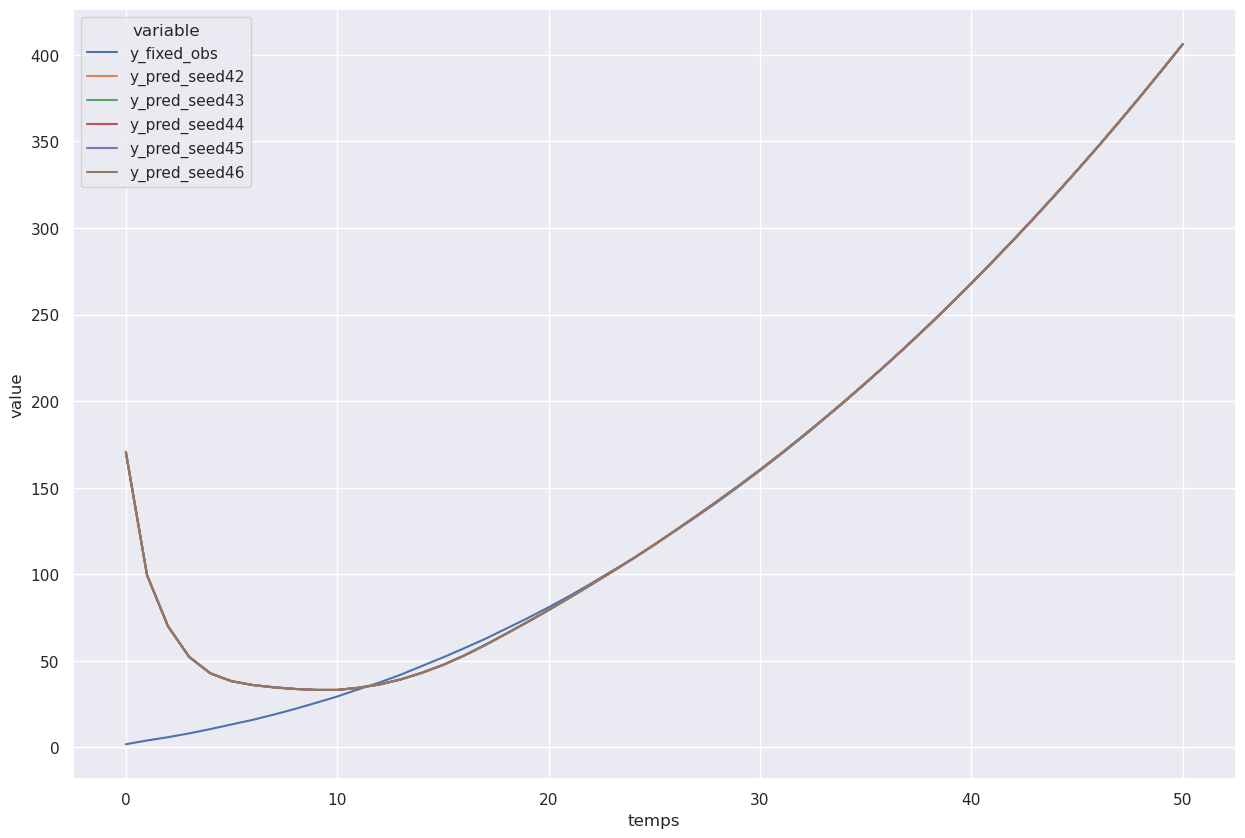

In [11]:
sns.lineplot(data_plot, x="temps", y="value", hue="variable")

## 

# Test on two individual

We take the:
- one with max y value
- one with min y value

In [12]:
ind_max = data[data[y_labels[0]] == data[y_labels[0]].max()]["individus"]
ind_max

5252    103
Name: individus, dtype: int64

In [13]:
ind_min = data[data[y_labels[0]] == data[y_labels[0]].min()]["individus"]
ind_min

662    13
Name: individus, dtype: int64

In [14]:
ind_list = [ind_max.iloc[0], ind_min.iloc[0]]

data_train = data[data["individus"].isin(ind_list)]
data_train

,individus,temps,x1,x2,x3,x4,x5,x6,x7,x8,y_fixed_obs
612,13,0,0.263562,0.175633,1.234770,-0.455305,6.175755e-02,0.827065,-5.233580e-01,0,0.186703
613,13,1,0.648734,-0.817575,1.233856,-0.519208,4.230100e-02,1.493190,-4.760812e-01,0,-0.689962
614,13,2,1.033906,-1.398564,1.231114,-0.577029,2.635803e-02,2.354665,-4.295698e-01,0,-1.927791
615,13,3,1.419078,-1.810782,1.226544,-0.629348,1.529241e-02,3.411491,-3.845402e-01,0,-3.815379
616,13,4,1.804250,-2.130524,1.220146,-0.676689,8.467486e-03,4.663667,-3.416180e-01,0,-6.699149
...,...,...,...,...,...,...,...,...,...,...,...
5248,103,46,-11.292926,4.031125,1.364331,-0.430472,-4.142625e-13,126.287408,-6.930154e-21,0,347.151230
5249,103,47,-11.530473,4.049421,1.340661,-0.429652,-2.232045e-13,130.884338,-2.537346e-21,0,361.385648
5250,103,48,-11.768020,4.067340,1.316482,-0.428909,-1.202625e-13,135.563444,-9.290017e-22,0,376.062921
5251,103,49,-12.005568,4.084896,1.291794,-0.428237,-6.479737e-14,140.324727,-3.401365e-22,0,390.909217


In [15]:
N_train = len(data_train["individus"].unique())
T_train = len(data_train["temps"].unique())
P_train = len(x_labels)
Y_train = len(y_labels)

scaler_x = RobustScaler()
scaler_y = RobustScaler()

x_train = data_train[x_labels]
y_train = data_train[y_labels]

x_train_scaled = scaler_x.fit_transform(x_train)
y_train_scaled = scaler_y.fit_transform(y_train)

x_train_3D = x_train_scaled.reshape([N_train, T_train, P_train])
y_train_3D = y_train_scaled.reshape([N_train, T_train, Y_train])

In [16]:
# from https://reservoirpy.readthedocs.io/en/latest/user_guide/quickstart.html#Create-the-ESN-model


data_pred = data_train.loc[:, ["individus", "temps"] + y_labels]

for seed in range(42, 47):

    reservoir = Reservoir(100, lr=0.5, sr=0.9, seed=42)
    readout = Ridge(ridge=1e-7)

    esn_model = reservoir >> readout
    esn_model.fit(x_train_3D, y_train_3D)

    y_pred_3D = np.array(
        esn_model.run(x_train_3D)
    )  # ATTENTION besoin de convertir avec N>1
    y_pred_scaled = y_pred_3D.reshape([N_train * T_train, Y_train])
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    data_pred[f"seed{seed}"] = y_pred


data_pred

,individus,temps,y_fixed_obs,seed42,seed43,seed44,seed45,seed46
612,13,0,0.186703,210.662225,210.662225,210.662225,210.662225,210.662225
613,13,1,-0.689962,121.723691,121.723691,121.723691,121.723691,121.723691
614,13,2,-1.927791,122.223107,122.223107,122.223107,122.223107,122.223107
615,13,3,-3.815379,139.084424,139.084424,139.084424,139.084424,139.084424
616,13,4,-6.699149,149.914591,149.914591,149.914591,149.914591,149.914591
...,...,...,...,...,...,...,...,...
5248,103,46,347.151230,347.128486,347.128486,347.128486,347.128486,347.128486
5249,103,47,361.385648,361.422205,361.422205,361.422205,361.422205,361.422205
5250,103,48,376.062921,376.042842,376.042842,376.042842,376.042842,376.042842
5251,103,49,390.909217,390.962057,390.962057,390.962057,390.962057,390.962057


In [17]:
data_plot = data_pred.melt(id_vars=["individus", "temps"])
data_plot["variable"] = (
    "ind#" + data_plot["individus"].map(str) + "_" + data_plot["variable"]
)
data_plot

,individus,temps,variable,value
0,13,0,ind#13_y_fixed_obs,0.186703
1,13,1,ind#13_y_fixed_obs,-0.689962
2,13,2,ind#13_y_fixed_obs,-1.927791
3,13,3,ind#13_y_fixed_obs,-3.815379
4,13,4,ind#13_y_fixed_obs,-6.699149
...,...,...,...,...
607,103,46,ind#103_seed46,347.128486
608,103,47,ind#103_seed46,361.422205
609,103,48,ind#103_seed46,376.042842
610,103,49,ind#103_seed46,390.962057


<Axes: xlabel='temps', ylabel='value'>

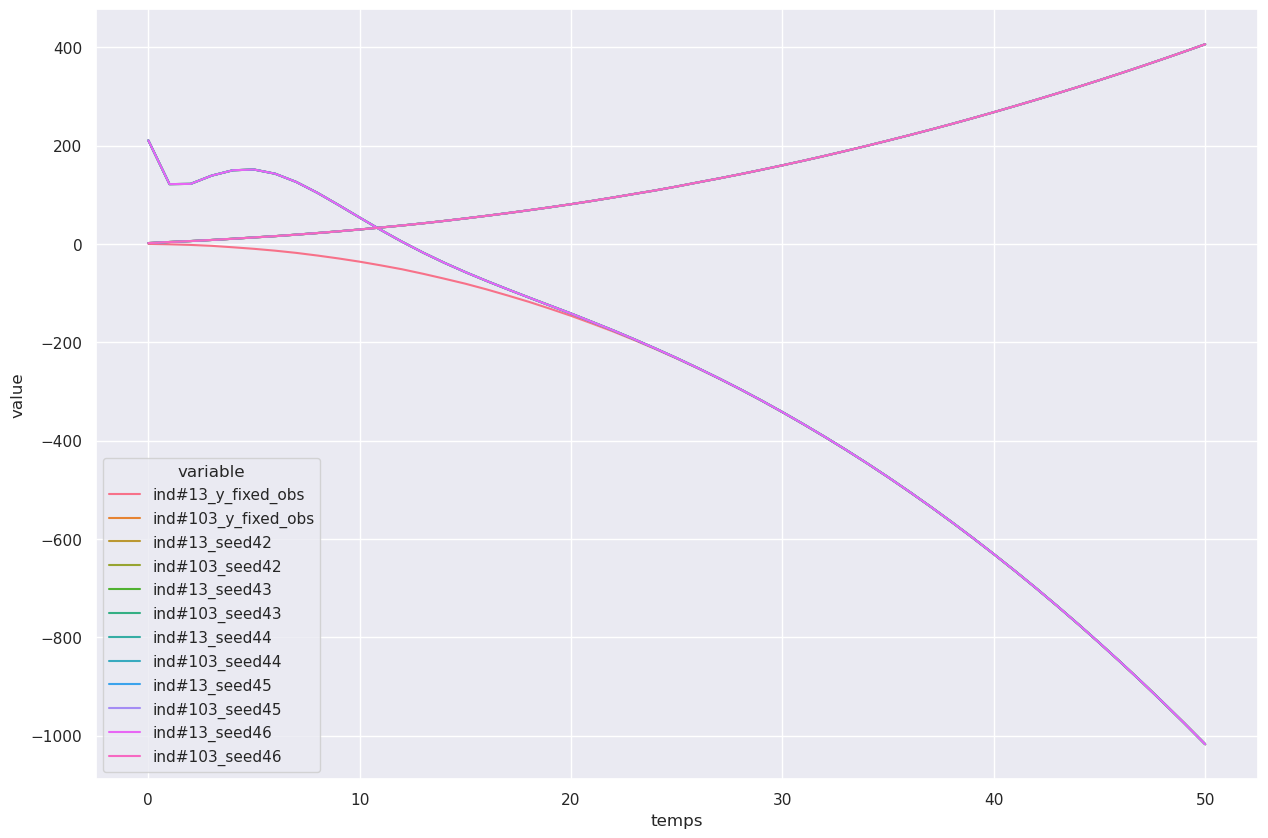

In [18]:
sns.lineplot(data_plot, x="temps", y="value", hue="variable")